INFO:lightning_fabric.utilities.seed:Seed set to 1234
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | digit_emb | Embedding        | 5.6 K  | train
1 | encoder   | LSTM             | 3.2 M  | train
2 | att       | DotAttention     | 0      | train
3 | to_output | Linear           | 4.6 K  | train
4 | criterion | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │    0.3680456578731537     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 1.0, 'test_loss': 0.3680456578731537}]


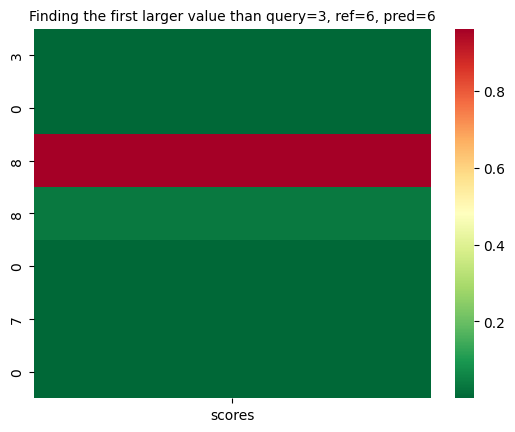

In [6]:
#출처 : https://github.com/hugman

# 행에 데이터가 여러개 있다. 원하는것은 쿼리와 같은 차원의 결과물
# dot attention 계산 이후 도출되는 결과는 쿼리 각각이 아이템을 참조하고 난 이후의 쿼리 벡터이다
# 쿼리벡터를 완전 연결층(wx + b) 연결 pred값 도출

# 3 0 8 8 0 7 0 에  답은6 에측값6
# 핵심은 쿼리가 아이템을 얼마나 참조하나 fully((softmax(item*query^t) * item))

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchmetrics import functional as FM
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from argparse import ArgumentParser
from pytorch_lightning.callbacks import EarlyStopping

class DotAttention(nn.Module):
    def __init__(self, item_dim, query_dim, attention_dim):
        super(DotAttention, self).__init__()
        self.item_dim = item_dim
        self.query_dim = query_dim
        self.attention_dim = attention_dim
        assert query_dim == item_dim, "Dot attention require dim. of query and dim. of item is same."

    def _calculate_reactivity(self, query_vector, multiple_items):
        query_vector = query_vector.unsqueeze(-1)
        reactivity_scores = torch.bmm(multiple_items, query_vector)
        reactivity_scores = reactivity_scores.squeeze(-1)
        return reactivity_scores

    def forward(self, query_vector, multiple_items, mask):
        assert mask is not None, "mask is required"
        B, N, H = multiple_items.size()
        reactivity_scores = self._calculate_reactivity(query_vector, multiple_items)
        reactivity_scores.data.masked_fill_(mask == 0, -float('inf'))
        attention_scores = F.softmax(reactivity_scores, dim=1)
        attention_scores = attention_scores.unsqueeze(1)
        blendded_vector = torch.matmul(attention_scores, multiple_items)
        blendded_vector = blendded_vector.squeeze(1)
        return blendded_vector, attention_scores

def load_data(fn):
    data = []
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip()
            seq_str, query, y = line.split('\t')
            seqs = seq_str.split(',')
            data.append((seqs, query, y))
    return data

class NumberDataset(Dataset):
    def __init__(self, fn, input_vocab, output_vocab, max_seq_length):
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.max_seq_length = max_seq_length
        self.data = load_data(fn)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, q, y = self.data[idx]
        seq_ids = [self.input_vocab[t] for t in seq]
        pad_id = self.input_vocab['<pad>']
        num_to_fill = self.max_seq_length - len(seq)
        seq_ids = seq_ids + [pad_id] * num_to_fill
        weights = [1] * len(seq) + [0] * num_to_fill
        q_id = self.input_vocab[q]
        y_id = self.output_vocab[y]
        item = [np.array(seq_ids), q_id, np.array(weights), y_id]
        return item

class NumberDataModule(pl.LightningDataModule):
    def __init__(self, max_seq_length=12, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length
        input_vocab, output_vocab = self.make_vocab('/content/train.txt')
        self.input_vocab_size = len(input_vocab)
        self.output_vocab_size = len(output_vocab)
        self.padding_idx = input_vocab['<pad>']
        self.input_r_vocab = {v: k for k, v in input_vocab.items()}
        self.output_r_vocab = {v: k for k, v in output_vocab.items()}
        self.all_train_dataset = NumberDataset('/content/train.txt', input_vocab, output_vocab, max_seq_length)
        self.test_dataset = NumberDataset('/content/test.txt', input_vocab, output_vocab, max_seq_length)
        N = len(self.all_train_dataset)
        tr = int(N * 0.8)
        va = N - tr
        self.train_dataset, self.valid_dataset = torch.utils.data.random_split(self.all_train_dataset, [tr, va])

    def make_vocab(self, fn):
        input_tokens = []
        output_tokens = []
        data = load_data(fn)
        for seqs, query, y in data:
            for token in seqs:
                input_tokens.append(token)
            output_tokens.append(y)
        input_tokens = list(set(input_tokens))
        output_tokens = list(set(output_tokens))
        input_tokens.sort()
        output_tokens.sort()
        input_tokens = ['<pad>'] + input_tokens
        input_vocab = {str(token): index for index, token in enumerate(input_tokens)}
        output_vocab = {str(token): index for index, token in enumerate(output_tokens)}
        return input_vocab, output_vocab

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

class Attention_Number_Finder(pl.LightningModule):
    def __init__(self, input_vocab_size, output_vocab_size, d_model, padding_idx, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.digit_emb = nn.Embedding(self.hparams.input_vocab_size, self.hparams.d_model, padding_idx=self.hparams.padding_idx)
        self.encoder = nn.LSTM(d_model, int(self.hparams.d_model / 2), num_layers=2, bidirectional=True, batch_first=True)
        self.att = DotAttention(item_dim=self.hparams.d_model, query_dim=self.hparams.d_model, attention_dim=self.hparams.d_model)
        self.to_output = nn.Linear(self.hparams.d_model, self.hparams.output_vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, seq_ids, q_id, weight):
        seq_embs = self.digit_emb(seq_ids.long())
        seq_encs, _ = self.encoder(seq_embs)
        query = self.digit_emb(q_id)
        multiple_items = seq_encs
        blendded_vector, attention_scores = self.att(query, multiple_items, mask=weight)
        blendded_vector = blendded_vector.squeeze(1)
        logits = self.to_output(blendded_vector)
        return logits, attention_scores

    def training_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        prob = F.softmax(logits, dim=-1)
        acc = FM.accuracy(prob, y_id, task='multiclass', num_classes=self.hparams.output_vocab_size)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
        return metrics

    def validation_step_end(self, val_step_outputs):
        val_acc = val_step_outputs['val_acc'].cpu()
        val_loss = val_step_outputs['val_loss'].cpu()
        self.log('validation_acc', val_acc, prog_bar=True)
        self.log('validation_loss', val_loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        prob = F.softmax(logits, dim=-1)
        acc = FM.accuracy(prob, y_id, task='multiclass', num_classes=self.hparams.output_vocab_size)
        metrics = {'test_acc': acc, 'test_loss': loss}
        self.log_dict(metrics, on_epoch=True)
        return metrics

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("ATTENTION")
        parser.add_argument('--learning_rate', type=float, default=0.00001)
        return parent_parser

def check_attention(model, ex, input_vocab, output_vocab):
    seq_ids, q_id, weights, y_id = ex
    seq_ids = seq_ids.to(model.device)
    q_id = q_id.to(model.device)
    weights = weights.to(model.device)
    os.makedirs('./output_figs/Dot', exist_ok=True)
    with torch.no_grad():
        logits, att_scores = model(seq_ids, q_id, weights)
        prob = F.softmax(logits, dim=-1)
        y_id_pred = prob.argmax(dim=-1)
        for idx, (a_seq_ids, a_q_id, a_weights, a_y_id, a_y_id_pred, a_att_scores) in enumerate(zip(seq_ids, q_id, weights, y_id, y_id_pred, att_scores)):
            N = a_weights.sum().item()

            input_sym = [input_vocab[i.item()] for i in a_seq_ids[:N]]
            q_sym = input_vocab[a_q_id.item()]

            ref_y_sym = output_vocab[a_y_id.item()] #오류 수정
            pred_y_sym = output_vocab[a_y_id_pred.item()]

            scores = a_att_scores.cpu().detach().numpy()[0][:N].tolist()
            data = {'scores': []}
            for word, score in zip(input_sym, scores):
                data['scores'].append(score)
                df = pd.DataFrame(data)
            df.index = input_sym
            plt.figure()
            sns.heatmap(df, cmap='RdYlGn_r')
            plt.title(f'Finding the first larger value than query={q_sym}, ref={ref_y_sym}, pred={pred_y_sym}', fontsize=10)
            plt.savefig(os.path.join('./output_figs/Dot', f'{idx}.png'))

def cli_main():
    pl.seed_everything(1234)
    parser = ArgumentParser()
    parser.add_argument('--batch_size', default=200, type=int)
    parser.add_argument('--d_model', default=512, type=int)
    parser.add_argument('--max_epochs', type=int, default=20)
    parser.add_argument('--accelerator', type=str, default='gpu')
    parser.add_argument('--devices', type=int, default=1)
    parser = Attention_Number_Finder.add_model_specific_args(parser)
    args, unknown = parser.parse_known_args()
    dm = NumberDataModule(
        max_seq_length=12,
        batch_size=args.batch_size
    )
    model = Attention_Number_Finder(dm.input_vocab_size, dm.output_vocab_size, args.d_model, dm.padding_idx, args.learning_rate)
    trainer = pl.Trainer(max_epochs=args.max_epochs, callbacks=[EarlyStopping(monitor='val_loss')], accelerator=args.accelerator, devices=args.devices)
    trainer.fit(model, datamodule=dm)
    result = trainer.test(model, datamodule=dm)
    print(result)
    ex_batch = next(iter(dm.test_dataloader()))
    check_attention(model, ex_batch, dm.input_r_vocab, dm.output_r_vocab)

if __name__ == '__main__':
    cli_main()


In [2]:
!pip install pytorch-lightning
#

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.2 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 1234
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | digit_emb | Embedding        | 5.6 K  | train
1 | encoder   | LSTM             | 3.2 M  | train
2 | att       | Attention        | 1.1 M  | train
3 | to_output | Linear           | 4.6 K  | train
4 | criterion | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.000285584683297202    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 1.0, 'test_loss': 0.000285584683297202}]


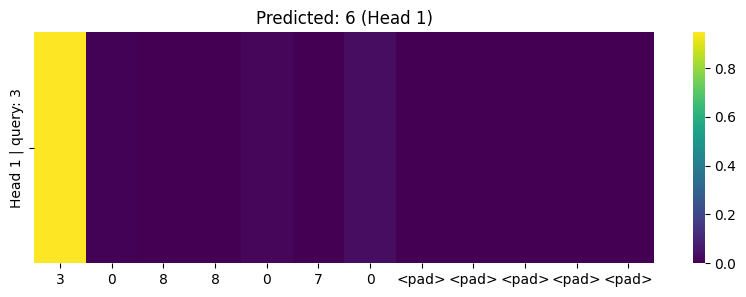

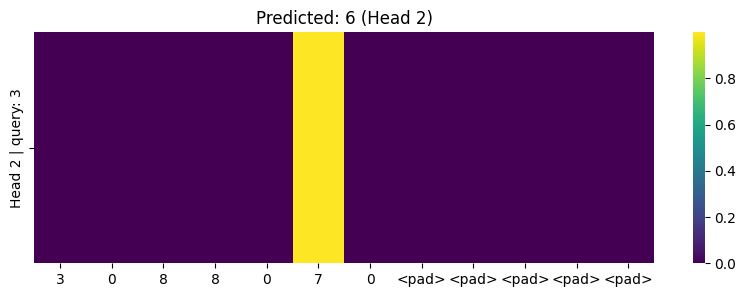

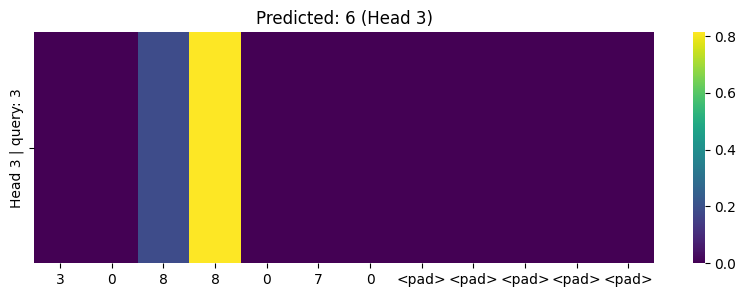

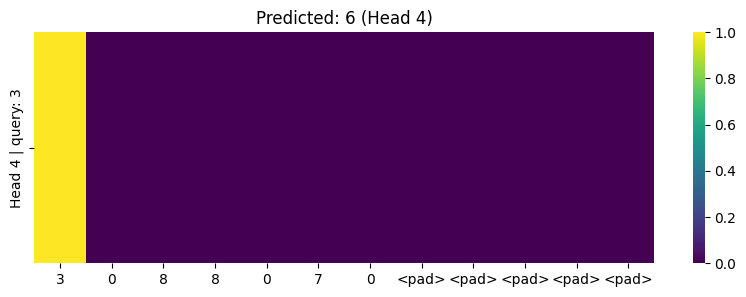

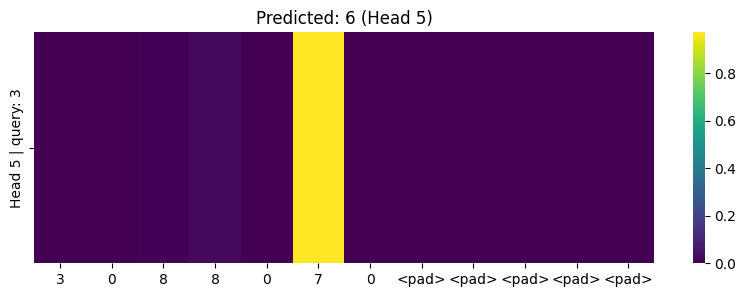

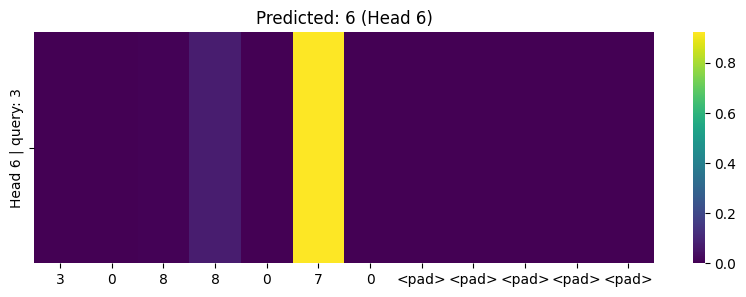

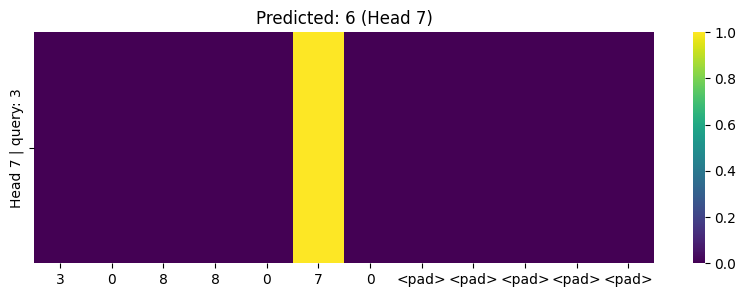

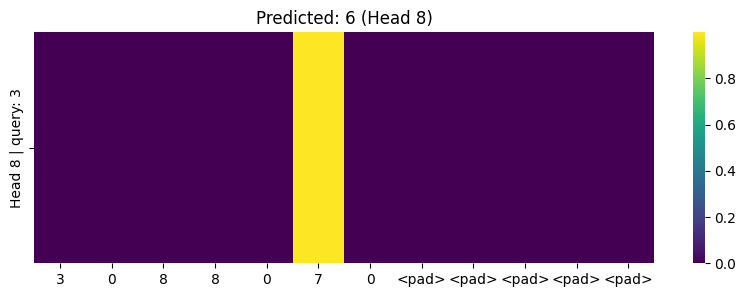

In [25]:
# 지금 이 코드에선 key, value에 두 개다 item 벡터를 사용하고 있다

# 데이터가 여러개 있다 ,임베딩 처리된 이후의 데이터를 헤드수만큼 분리해준다 , 이후 헤드별 attention,
# softmax -> value(코드상에선 item) 과 곱해준다
# 이후 각 dot_product계산한 헤드 들을 연결 -> fully connected .

# 임베딩된 고차원 데이터를 다양한 관점에서 바라보고 이 각각을 합쳐서 판단하여 결과를 예측해보자.


import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchmetrics import functional as FM
from argparse import ArgumentParser
from pytorch_lightning.callbacks import EarlyStopping


def scaled_dot_product_attention(q, k, v, mask=None, dropout=0.1):
    d_k = k.size()[-1]
    attn = torch.matmul(q, k.transpose(-2, -1))
    if mask is not None:
        inverted_mask = 1.0 - mask
        inverted_mask = inverted_mask.masked_fill(inverted_mask.bool(), torch.finfo(attn.dtype).min)
        attn = attn + inverted_mask
    attention_weights = F.softmax(attn, dim=-1)
    if isinstance(dropout, float):
        attention_weights = F.dropout(attention_weights, dropout)
    else:
        attention_weights = dropout(attention_weights)
    output = torch.matmul(attention_weights, v)
    return output, attention_weights


class Attention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1, use_bias=True):
        super(Attention, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads
        self.wq = nn.Linear(d_model, d_model, bias=use_bias)
        self.wk = nn.Linear(d_model, d_model, bias=use_bias)
        self.wv = nn.Linear(d_model, d_model, bias=use_bias)
        self.dropout = nn.Dropout(dropout)
        self.wo = nn.Linear(d_model, d_model, bias=use_bias)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        x = x.transpose(1, 2).contiguous()
        return x

    def forward(self, query, key, value, mask=None):
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        _, qS = q.size()[0], q.size()[1]
        B, S = k.size()[0], k.size()[1]
        q = self.split_heads(q, B)
        k = self.split_heads(k, B)
        v = self.split_heads(v, B)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask, self.dropout)
        scaled_attention = scaled_attention.transpose(1, 2)
        concat_attention = scaled_attention.reshape(B, qS, -1)
        output = self.wo(concat_attention)
        return output, attention_weights


def load_data(fn):
    data = []
    with open(fn, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip()
            seq_str, query, y = line.split('\t')
            seqs = seq_str.split(',')
            data.append((seqs, query, y))
    return data


class NumberDataset(Dataset):
    def __init__(self, fn, input_vocab, output_vocab, max_seq_length):
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.max_seq_length = max_seq_length
        self.data = load_data(fn)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, q, y = self.data[idx]
        seq_ids = [self.input_vocab[t] for t in seq]
        pad_id = self.input_vocab['<pad>']
        num_to_fill = self.max_seq_length - len(seq)
        seq_ids = seq_ids + [pad_id] * num_to_fill
        weights = [1] * len(seq) + [0] * num_to_fill
        q_id = self.input_vocab[q]
        y_id = self.output_vocab[y]
        item = [np.array(seq_ids), q_id, np.array(weights), y_id]
        return item


class NumberDataModule(pl.LightningDataModule):
    def __init__(self, max_seq_length: int = 12, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length
        input_vocab, output_vocab = self.make_vocab('/content/train.txt')
        self.input_vocab_size = len(input_vocab)
        self.output_vocab_size = len(output_vocab)
        self.padding_idx = input_vocab['<pad>']
        self.input_r_vocab = {v: k for k, v in input_vocab.items()}
        self.output_r_vocab = {v: k for k, v in output_vocab.items()}
        self.all_train_dataset = NumberDataset('/content/train.txt', input_vocab, output_vocab, max_seq_length)
        self.test_dataset = NumberDataset('/content/test.txt', input_vocab, output_vocab, max_seq_length)
        N = len(self.all_train_dataset)
        tr = int(N * 0.8)
        va = N - tr
        self.train_dataset, self.valid_dataset = torch.utils.data.random_split(self.all_train_dataset, [tr, va])

    def make_vocab(self, fn):
        input_tokens = []
        output_tokens = []
        data = load_data(fn)
        for seqs, query, y in data:
            for token in seqs:
                input_tokens.append(token)
            output_tokens.append(y)
        input_tokens = list(set(input_tokens))
        output_tokens = list(set(output_tokens))
        input_tokens.sort()
        output_tokens.sort()
        input_tokens = ['<pad>'] + input_tokens
        input_vocab = {str(token): index for index, token in enumerate(input_tokens)}
        output_vocab = {str(token): index for index, token in enumerate(output_tokens)}
        return input_vocab, output_vocab

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


class Attention_Number_Finder(pl.LightningModule):
    def __init__(self, input_vocab_size, output_vocab_size, d_model, num_heads, padding_idx, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.digit_emb = nn.Embedding(self.hparams.input_vocab_size, self.hparams.d_model, padding_idx=self.hparams.padding_idx)
        self.encoder = nn.LSTM(d_model, int(self.hparams.d_model / 2), num_layers=2, bidirectional=True, batch_first=True)
        self.att = Attention(d_model=self.hparams.d_model, num_heads=self.hparams.num_heads)
        self.to_output = nn.Linear(self.hparams.d_model, self.hparams.output_vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, seq_ids, q_id, weight):
        seq_embs = self.digit_emb(seq_ids.long())
        seq_encs, _ = self.encoder(seq_embs)
        query = self.digit_emb(q_id)
        query = query.unsqueeze(1)
        multiple_items = seq_encs
        mask = weight[:, None, None, :]
        blended_vector, attention_scores = self.att(query=query, key=multiple_items, value=multiple_items, mask=mask)
        blended_vector = blended_vector.squeeze(1)
        logits = self.to_output(blended_vector)
        return logits, attention_scores

    def training_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        prob = F.softmax(logits, dim=-1)
        acc = FM.accuracy(prob, y_id, task='multiclass', num_classes=self.hparams.output_vocab_size)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx):
        seq_ids, q_id, weights, y_id = batch
        logits, _ = self(seq_ids, q_id, weights)
        loss = self.criterion(logits, y_id.long())
        prob = F.softmax(logits, dim=-1)
        acc = FM.accuracy(prob, y_id, task='multiclass', num_classes=self.hparams.output_vocab_size)
        metrics = {'test_acc': acc, 'test_loss': loss}
        self.log_dict(metrics, on_epoch=True)
        return metrics

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("ATTENTION")
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        return parent_parser


import matplotlib.pyplot as plt
import seaborn as sns

def check_attention(model, batch, input_vocab, output_vocab):
    model.eval()
    seq_ids, q_id, weights, y_id = batch
    with torch.no_grad():
        logits, att_scores = model(seq_ids, q_id, weights)

    # attention: [B, num_heads, query_len, seq_len]
    att = att_scores[0].cpu().numpy()

    seq_tokens = [input_vocab[i.item()] for i in seq_ids[0]]
    query_token = input_vocab[q_id[0].item()]
    pred_token = output_vocab[logits.argmax(dim=-1)[0].item()]

    import matplotlib.pyplot as plt
    import seaborn as sns


    # average of head attention
    """att = att.mean(axis=0)  # [query_len, seq_len]
    plt.figure(figsize=(10, 3))
    sns.heatmap(att, xticklabels=seq_tokens, yticklabels=[f"query: {query_token}"], cmap="viridis")
    plt.title(f"Predicted: {pred_token}")
    plt.show()
    """
    num_heads = att.shape[0]

    for h in range(num_heads):
        head_att = att[h]
        plt.figure(figsize=(10, 3))
        sns.heatmap(head_att, xticklabels=seq_tokens, yticklabels=[f"Head {h+1} | query: {query_token}"], cmap="viridis")
        plt.title(f"Predicted: {pred_token} (Head {h+1})")
        plt.show()



def cli_main():
    pl.seed_everything(1234)
    parser = ArgumentParser()
    parser.add_argument('--batch_size', default=200, type=int)
    parser.add_argument('--d_model', default=512, type=int)
    parser.add_argument('--num_heads', default=8, type=int)
    parser = Attention_Number_Finder.add_model_specific_args(parser)
    args, _ = parser.parse_known_args()
    dm = NumberDataModule(max_seq_length=12, batch_size=args.batch_size)
    next(iter(dm.train_dataloader()))
    model = Attention_Number_Finder(dm.input_vocab_size, dm.output_vocab_size, args.d_model, args.num_heads, dm.padding_idx, args.learning_rate)
    accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
    trainer = pl.Trainer(max_epochs=20, callbacks=[EarlyStopping(monitor='val_loss')], accelerator=accelerator, devices=1)
    trainer.fit(model, datamodule=dm)
    result = trainer.test(model, datamodule=dm)
    print(result)
    ex_batch = next(iter(dm.test_dataloader()))
    check_attention(model, ex_batch, dm.input_r_vocab, dm.output_r_vocab)



if __name__ == '__main__':
    cli_main()
